In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.mask
import numpy.ma as np_ma

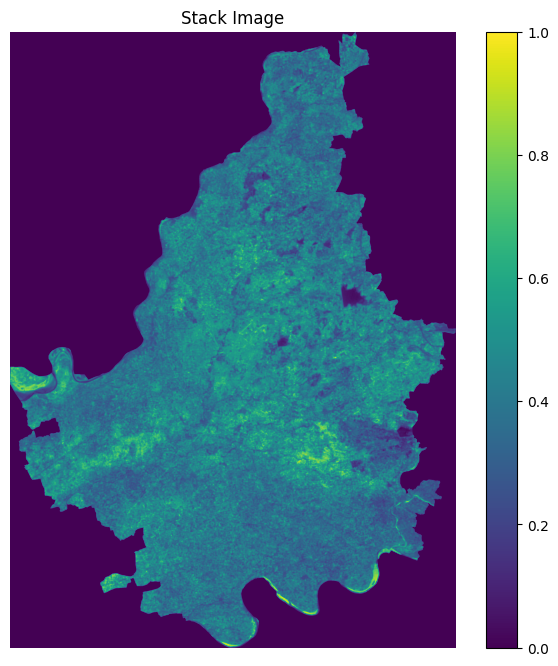

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Assuming the file is in Google Drive and mounted
file_path = "/content/gdrive/MyDrive/NR_STACK_MERGE_TEST.tif"    #HERE THE NR_STACK_MERGE_TEST.tif FILE PATH

# Open the raster image file
try:
    src = rasterio.open(file_path)
except rasterio.errors.RasterioIOError as e:
    print(f"Error opening the raster file: {e}")
    raise

# Read the image data for bands 1, 2, and 3
band1_data = src.read(1)
band2_data = src.read(2)
band3_data = src.read(3)

# Display the raster image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(band1_data, cmap='viridis')
plt.colorbar()
plt.title("Stack Image")
plt.axis('off')
plt.show()

# Close the raster file
src.close()


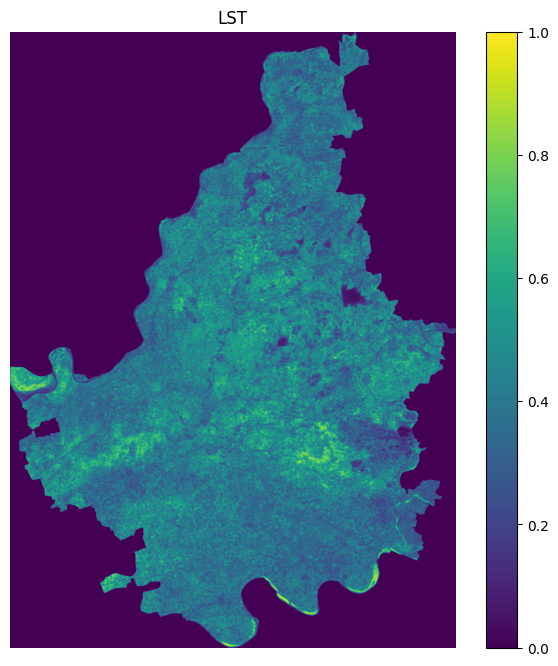

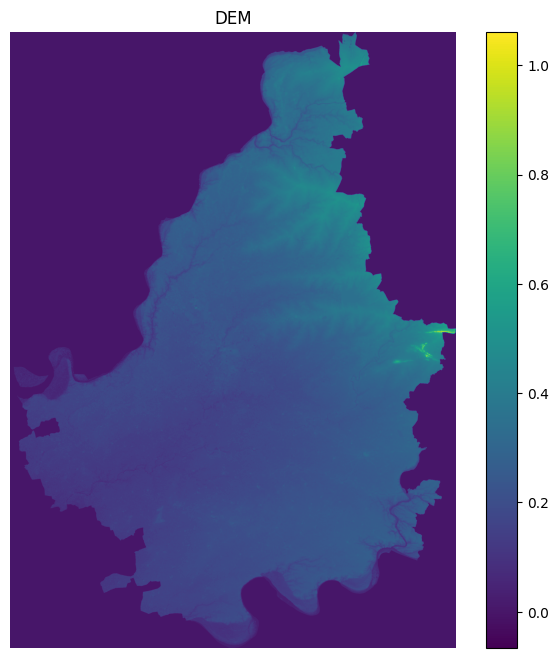

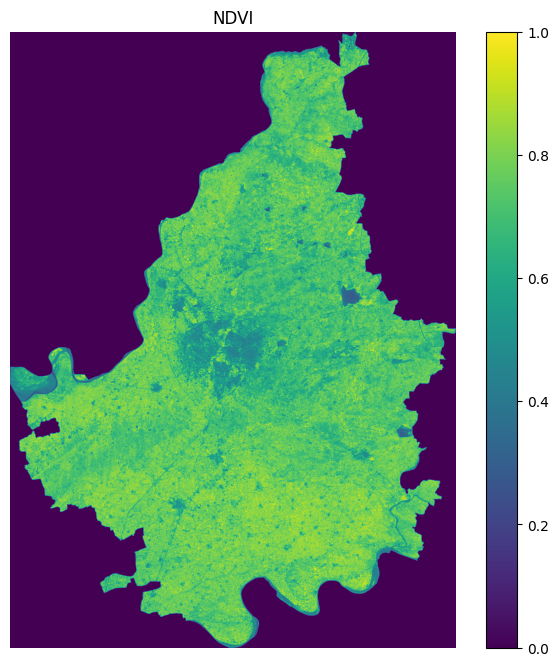

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

# Open the raster image file
file_path = "/content/gdrive/MyDrive/NR_STACK_MERGE_TEST.tif"
src = rasterio.open(file_path)

# Read the image data for NDVI,DEM,LST
band1_data = src.read(1)
band2_data = src.read(2)
band3_data = src.read(3)

# Close the raster file
src.close()

# Reshape the data to 1D arrays
band1_flat = band1_data.flatten()
band2_flat = band2_data.flatten()
band3_flat = band3_data.flatten()

# Create a DataFrame using pandas
df = pd.DataFrame({
    'Band1': band1_flat,
    'Band2': band2_flat,
    'Band3': band3_flat
})


# Display the raster image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(band1_data, cmap='viridis')
plt.colorbar()
plt.title("LST")
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(band2_data, cmap='viridis')
plt.colorbar()
plt.title("DEM")
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(band3_data, cmap='viridis')
plt.colorbar()
plt.title("NDVI")
plt.axis('off')
plt.show()


Test RMSE: 229.8830
Test MAE: 191.5230


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



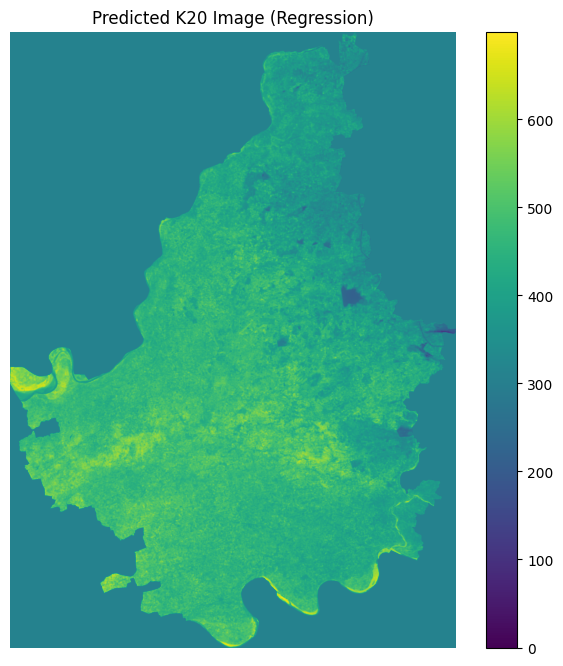

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your dataset for training
file_path = "/content/SAMPLE_RASTER_MERGE_TSET.csv"     #HERE SAMPLE_RASTER_MERGE_TSET.csv FILE PATH
df = pd.read_csv(file_path)

# # Assuming df is your DataFrame with the column 'EC'
# scaler = MinMaxScaler()

# # Fit and transform the single column using the MinMaxScaler
# scaled_column = scaler.fit_transform(df[['P2O5_kg_ha']])

# # Create a new DataFrame with the scaled column
# Y_PRE = pd.DataFrame(scaled_column, columns=['P2O5_kg_ha'])

Y_PRE = df[['K20_kg_ha_']]    #HERE THE PREDICTED COLUMN VALUE
# Extract the relevant columns for training and prediction
features = ['NDVI', 'DEM', 'LST']
target = Y_PRE

# Split the data into features (X) and target (y)
X = df[features]
y = target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the trained model to a file
model_save_path = "/content/trained_ec_model.joblib"     #SAVE THE MODEL PATH
joblib.dump(model, model_save_path)

# Load the raster image file
file_path = "/content/gdrive/MyDrive/NR_STACK_MERGE_TEST.tif"    #HERE NR_STACK_MERGE_TEST.tif FILE PATH
src = rasterio.open(file_path)

# Read the image data for bands 1, 2, and 3
band1_data = src.read(1)
band2_data = src.read(2)
band3_data = src.read(3)

# Reshape the data to 1D arrays
band1_flat = band1_data.flatten()
band2_flat = band2_data.flatten()
band3_flat = band3_data.flatten()

# Normalize the bands using MinMaxScaler
scaler = MinMaxScaler()

band1_normalized = scaler.fit_transform(band1_flat.reshape(-1, 1)).flatten()
band2_normalized = scaler.fit_transform(band2_flat.reshape(-1, 1)).flatten()
band3_normalized = scaler.fit_transform(band3_flat.reshape(-1, 1)).flatten()

# Create a DataFrame using pandas
new_data = pd.DataFrame({
    'NDVI': band1_normalized,
    'DEM': band2_normalized,
    'LST': band3_normalized,
})

# Load the trained model
loaded_model = joblib.load(model_save_path)

# Make predictions on the new data
new_predictions = loaded_model.predict(new_data)

# Display the predicted values
# print("Predicted EC values for new data:", new_predictions)

# Create a DataFrame using pandas
df_classification = pd.DataFrame({
    'NDVI': list(band1_normalized),
    'DEM': list(band2_normalized),
    'LST': list(band3_normalized),
    'EC': list(new_predictions)
})

# Make predictions on the raster image for regression
X_raster_regression = df_classification[['NDVI', 'DEM', 'LST']]
df_classification['predicted_EC'] = loaded_model.predict(X_raster_regression)

# Reshape the predicted values to create a new raster image for regression
predicted_image_regression = df_classification['predicted_EC'].values.reshape(band1_data.shape)

modified_list = [[max(0, value) for value in row] for row in predicted_image_regression]


# Specify the path to save the predicted EC raster image
predicted_ec_image_path = "/content/predicted_K20_kg_ha_without_NR_image.tif"    #SAVE THE PREDICTED IMAGE FILE PATH
# print(predicted_image_regression)
# input_array = np.array(predicted_image_regression)


# Evaluate the model on the test set
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


# Flatten the list of lists
flat_list = [item for sublist in modified_list for item in sublist]

# # Find the minimum and maximum values
# min_value = min(modified_list)
# max_value = max(modified_list)

# print("Minimum value:", min_value)
# print("Maximum value:", max_value)


print(modified_list)

# Use MinMaxScaler to normalize each sublist independently
# scaler = MinMaxScaler()
# normalized_array = scaler.fit_transform(input_array)

# # Print the normalized values
# # print(normalized_array)

# min_value = np.min(normalized_array)
# max_value = np.max(normalized_array)

# print("Minimum value:", min_value)
# print("Maximum value:", max_value)

# Get the metadata from the original raster file
meta = src.meta

# Update metadata for the new raster file
meta.update(dtype='float32', count=1)

# Convert the list to a NumPy array
modified_array = np.array(modified_list, dtype=np.float32)

# Open the raster file for writing
with rasterio.open(predicted_ec_image_path, 'w', **meta) as dst:
    # Write the NumPy array to the raster file
    dst.write(modified_array, 1)
# Display the raster image for regression using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(modified_list, cmap='viridis')
plt.colorbar()
plt.title("Predicted K20 Image (Regression)")
plt.axis('off')
plt.show()

# Close the raster files
src.close()

